<a href="https://colab.research.google.com/github/SamuelaAnastasi/YelpMeKnow/blob/master/YelpMeKnow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#YelpMeKnow

YelpMeKnow is a text classifier model, which leverages the power of [Google's BERT](https://arxiv.org/pdf/1810.04805.pdf) pretrained models  through the [Hugging Face](https://github.com/huggingface/pytorch-transformers) Pytorch implementation. Specifically the BERT-Base-Uncased: 12-layer, 768-hidden, 12-heads, 110M parameters, is used.


The model performs a Sequence Classification analysis of the customer satisfaction, (positive vs. negative reviews), contained in [Yelp Review Polarity Dataset](https://course.fast.ai/datasets). 

The dataset containes 560,000 training samples and 38,000 testing samples, but due to limited resources and time I'm training/validating and testing on a really small subset of it.

Train data size: 20000 ~ 3.6% of training samples

Test data size: 2000 ~  5.3% of testing samples

Epochs: 1

Matthew's correlation coefficient: ~ 0.86

The accuracy of predictions is evaluated using [Matthew’s correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), which is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.


N.B.

[WORK IN PROGRESS] Data preparation and model require improvements and further training.


In [0]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [0]:
# imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
# Check GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
# Load the pretrained BERT model BertForSequenceClassification. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediat

In [0]:
# Get tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [0]:
# define helper functions
def read_csv_file(path):
  
  file = pd.read_csv(path, header=None)
  print('Data values:')
  print(file.head())
  print('\n')
  print('Data shape: ', file.shape)
  return file


def normalize_data_values(data):
  
  # labels column [0] has values 1 and 2 for respectively negative and positive reviews
  # convert labels column values to 0 for negative and 1 for positive 
  data[0] = (data[0] == 2).astype(int)
  
  return data

def get_labels_and_reviews(data, num_entries):
  
  # get label and reviews up to num_entries 
  labels = data[0].values[:num_entries]  
  reviews = data[1].values[:num_entries]
  
  # print first 5 labels and reviews  
  print('First 5 labels: ', labels[:5])
  print('First 5 reviews:')
  print(reviews[:5])
  
  print('\n')
  print('Labels size: ', len(labels))
  print('Reviews size: ', len(reviews))
  
  return labels, reviews


def tokenize_pad_reviews(reviews, max_len=128):
  
  max_len -= 2
  all_tokens_ids = []
  
  for review in tqdm(reviews):
    
    review_tokens = tokenizer.tokenize(review)
    
    if len(review_tokens) > max_len:
      
            review_tokens = review_tokens[:max_len]
        
    one_tokens_ids = tokenizer.convert_tokens_to_ids(["[CLS]"] + review_tokens + ["[SEP]"]) + [0] * (max_len - len(review_tokens))    
    all_tokens_ids.append(one_tokens_ids)    
  
  print('\n')
  print('Tokens ids for the first review:')  
  print(all_tokens_ids[0])
  
  return np.array(all_tokens_ids)


def create_attention_masks(reviews_tokens_ids):
  
  # Create attention masks for trainset token sequences: 1 for token - 0 for padding
  attention_masks = []
  
  for token_seq in reviews_tokens_ids:
    
    token_seq_mask = [float(i > 0) for i in token_seq]
    attention_masks.append(token_seq_mask)    
  
  print(attention_masks[0])
  return attention_masks


def split_data_and_masks(data, labels, masks, seed=1042, split_factor=0.1):
  
  inputs_train, inputs_val, labels_train, labels_val = train_test_split(data, labels, 
                                                            random_state=seed, test_size=split_factor)
  
  masks_train, masks_val, _, _ = train_test_split(masks, data,
                                             random_state=seed, test_size=split_factor)
  
  # Convert data in tensors
  return (torch.tensor(inputs_train), torch.tensor(inputs_val), 
          torch.tensor(labels_train), torch.tensor(labels_val), 
          torch.tensor(masks_train), torch.tensor(masks_val))


def get_train_loader(inputs, masks, labels, batch_size=32):
  
  data = TensorDataset(inputs, masks, labels)
  sampler = RandomSampler(data)
  loader = DataLoader(data, sampler=sampler, batch_size=batch_size)
  
  return loader


def get_val_test_loader(inputs, masks, labels, batch_size=32):
  
  data = TensorDataset(inputs, masks, labels)
  sampler = SequentialSampler(data)
  loader = DataLoader(data, sampler=sampler, batch_size=batch_size)
  
  return loader


###Read and prepare data - Build model and train

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# data path files
train_file_path = "/gdrive/My Drive/Colab Notebooks/yelp/yelp_review_polarity_csv/train.csv"
test_file_path = "/gdrive/My Drive/Colab Notebooks/yelp/yelp_review_polarity_csv/test.csv"

In [0]:
train_df = read_csv_file(train_file_path)

Data values:
   0                                                  1
0  1  Unfortunately, the frustration of being Dr. Go...
1  2  Been going to Dr. Goldberg for over 10 years. ...
2  1  I don't know what Dr. Goldberg was like before...
3  1  I'm writing this review to give you a heads up...
4  2  All the food is great here. But the best thing...


Data shape:  (560000, 2)


In [0]:
train_df = normalize_data_values(train_df)

In [0]:
num_entries = 20000
labels_all, reviews_all = get_labels_and_reviews(train_df, num_entries)

First 5 labels:  [0 1 0 0 1]
First 5 reviews:
["Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."
 "Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you 

In [0]:
MAX_LEN = 128
reviews_all_tokens_ids = tokenize_pad_reviews(reviews_all, max_len=MAX_LEN)

100%|██████████| 20000/20000 [00:58<00:00, 340.91it/s]




Tokens ids for the first review:
[101, 6854, 1010, 1996, 9135, 1997, 2108, 2852, 1012, 18522, 1005, 1055, 5776, 2003, 1037, 9377, 1997, 1996, 3325, 1045, 1005, 2310, 2018, 2007, 2061, 2116, 2060, 7435, 1999, 16392, 1011, 1011, 2204, 3460, 1010, 6659, 3095, 1012, 2009, 3849, 2008, 2010, 3095, 3432, 2196, 6998, 1996, 3042, 1012, 2009, 2788, 3138, 1016, 2847, 1997, 5567, 4214, 2000, 2131, 2019, 3437, 1012, 2040, 2038, 2051, 2005, 2008, 2030, 4122, 2000, 3066, 2007, 2009, 1029, 1045, 2031, 2448, 2046, 2023, 3291, 2007, 2116, 2060, 7435, 1998, 1045, 2074, 2123, 1005, 1056, 2131, 2009, 1012, 2017, 2031, 2436, 3667, 1010, 2017, 2031, 5022, 2007, 2966, 3791, 1010, 2339, 3475, 1005, 1056, 3087, 10739, 1996, 3042, 1029, 2009, 1005, 1055, 4297, 25377, 2890, 10222, 19307, 1998, 2025, 2147, 1996, 12943, 102]


In [0]:
train_all_attention_masks = create_attention_masks(reviews_all_tokens_ids)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [0]:
SEED = 1042
SPLIT_FACTOR = 0.1
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = split_data_and_masks(reviews_all_tokens_ids, 
                                                                        labels_all, train_all_attention_masks, 
                                                                        seed=SEED, split_factor=SPLIT_FACTOR)

In [0]:
batch_size = 32

train_loader = get_train_loader(train_inputs, train_masks, train_labels, batch_size=batch_size)
val_loader = get_val_test_loader(validation_inputs, validation_masks, validation_labels, batch_size=batch_size)

In [0]:
params = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']

optimizer_grouped_parameters = [
    {'params': [p for n, p in params if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in params if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [0]:
lr = 2e-5
warmup = 0.1
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=lr,
                     warmup=warmup)

t_total value of -1 results in schedule not being applied


###Train Model

In [0]:
epochs = 1

# Store loss and accuracy
train_losses = []

for _ in trange(epochs, desc="Epoch"):
  
  # Training   
  model.train()
  
  train_loss = 0
  train_examples, train_steps = 0, 0
  
  # Train model
  for step, data in enumerate(train_loader):
    
    # move data to GPU
    data = tuple(d.to(device) for d in data)
    data_input_ids, data_input_mask, data_labels = data
    
    # Clear gradients
    optimizer.zero_grad()
    
    loss = model(data_input_ids, token_type_ids=None, 
                 attention_mask=data_input_mask, labels=data_labels)
    train_losses.append(loss.item()) 
    
    # Backward pass
    loss.backward()
    # Update weights
    optimizer.step()    
    
    train_loss += loss.item()
    train_examples += data_input_ids.size(0)
    train_steps += 1
    
  print("Train loss: {}".format(train_loss/train_steps))
  
  # Validation
  model.eval()
  
  val_accuracy = 0
  val_steps = 0
  
  # Validate model for 1 epoch
  for data in val_loader:
    
    data = tuple(d.to(device) for d in data)
    data_input_ids, data_input_mask, data_labels = data
    
    with torch.no_grad():
      preds = model(data_input_ids, token_type_ids=None, 
                     attention_mask=data_input_mask)
    
    # Move predictions and labels to CPU
    preds = preds.detach().cpu().numpy()
    label_ids = data_labels.to('cpu').numpy()
    
    preds_flat, labels_flat = np.argmax(preds, axis=1).flatten(), label_ids.flatten()
    current_accuracy = np.sum(preds_flat == labels_flat) / len(labels_flat)
    
    val_accuracy += current_accuracy
    val_steps += 1
    
  print("Validation Accuracy: {}".format(val_accuracy/val_steps)) 


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.23867516163041813


Epoch: 100%|██████████| 1/1 [14:35<00:00, 875.56s/it]

Validation Accuracy: 0.9241071428571429


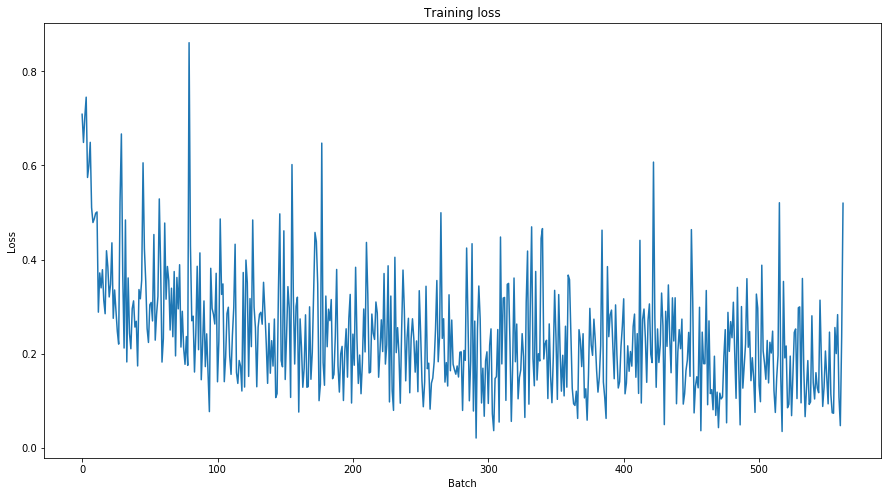

In [0]:
# Plot losses
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_losses)
plt.show()

### Read, prepare data and test

In [0]:
test_df = read_csv_file(test_file_path)

Data values:
   0                                                  1
0  2  Contrary to other reviews, I have zero complai...
1  1  Last summer I had an appointment to get new ti...
2  2  Friendly staff, same starbucks fair you get an...
3  1  The food is good. Unfortunately the service is...
4  2  Even when we didn't have a car Filene's Baseme...


Data shape:  (38000, 2)


In [0]:
test_df = normalize_data_values(test_df)

In [0]:
num_test_entries = 2000
test_labels, test_reviews = get_labels_and_reviews(test_df, num_test_entries)

First 5 labels:  [1 0 1 0 1]
First 5 reviews:
["Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Boys, these guys are experienced and know what they're doing. \\nAlso, this is one place that I do not feel like I am being taken advantage of, just because of my gender. Other auto mechanics have been notorious for capitalizing on my ignorance of cars, and have sucked my bank account dry. But here, my service and road coverage has all been well explained - and let up to me to decide. \\nAnd they just renovated the waiting room. It looks a lot better than it did in previous years."
 'Last summer I had an appointment to get new tires and had to wait a super long time. I also went in this week for them to fix a minor problem with a tire they put on. They \\"fixed\\" it for free, and the very next morning I had the same issue. I called to complain

In [0]:
MAX_LEN = 128
test_tokens_ids = tokenize_pad_reviews(test_reviews, max_len=MAX_LEN)

100%|██████████| 2000/2000 [00:05<00:00, 349.96it/s]




Tokens ids for the first review:
[101, 10043, 2000, 2060, 4391, 1010, 1045, 2031, 5717, 10821, 2055, 1996, 2326, 2030, 1996, 7597, 1012, 1045, 2031, 2042, 2893, 12824, 2326, 2182, 2005, 1996, 2627, 1019, 2086, 2085, 1010, 1998, 4102, 2000, 2026, 3325, 2007, 3182, 2066, 27233, 3337, 1010, 2122, 4364, 2024, 5281, 1998, 2113, 2054, 2027, 1005, 2128, 2725, 1012, 1032, 6583, 4877, 2080, 1010, 2023, 2003, 2028, 2173, 2008, 1045, 2079, 2025, 2514, 2066, 1045, 2572, 2108, 2579, 5056, 1997, 1010, 2074, 2138, 1997, 2026, 5907, 1012, 2060, 8285, 9760, 2031, 2042, 12536, 2005, 3007, 6026, 2006, 2026, 18173, 1997, 3765, 1010, 1998, 2031, 8631, 2026, 2924, 4070, 4318, 1012, 2021, 2182, 1010, 2026, 2326, 1998, 2346, 6325, 2038, 2035, 2042, 2092, 4541, 1011, 1998, 2292, 2039, 2000, 2033, 2000, 5630, 1012, 102]


In [0]:
test_attention_masks = create_attention_masks(test_tokens_ids)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [0]:
preds_inputs = torch.tensor(test_tokens_ids)
preds_masks = torch.tensor(test_attention_masks)
preds_labels = torch.tensor(test_labels)

In [0]:
test_loader = get_val_test_loader(preds_inputs, preds_masks, preds_labels, batch_size=batch_size)

In [0]:
# Prediction on test set
model.eval()

predictions, true_labels = [], []

# Predict 
for data in test_loader:
  
  # Move data to GPU
  data = tuple(d.to(device) for d in data)
  
  test_input_ids, test_input_mask, test_labels = data
  
  # Do not compute gradients
  with torch.no_grad(): 
    
    # calculate predictions
    preds = model(test_input_ids, token_type_ids=None, attention_mask=test_input_mask)

  # Move preds and labels to CPU
  preds = preds.detach().cpu().numpy()
  label_ids = test_labels.to('cpu').numpy()  
  
  predictions.append(preds)
  true_labels.append(label_ids)

In [0]:
# Evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef

matthews_set = []

for i in range(len(true_labels)):
  
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  
  matthews_set.append(matthews)

In [0]:
matthews_set

[1.0,
 0.8206518066482898,
 0.8096598849105344,
 0.938872452190116,
 0.8614718614718615,
 0.9315409787235999,
 0.9379228369755696,
 0.7490196078431373,
 0.9343531843023135,
 0.8643121965600912,
 0.9393364366277243,
 0.938872452190116,
 0.936441710371274,
 0.7984472665856134,
 0.7092993656151906,
 0.8823529411764706,
 0.7559289460184544,
 0.936441710371274,
 0.8050112948805689,
 0.7562449037944323,
 0.873015873015873,
 0.6888467201936644,
 0.6813969328454993,
 0.8140915784106943,
 0.8150678894028793,
 0.8545454545454545,
 0.8563488385776753,
 0.7333333333333333,
 0.8666666666666667,
 0.7530836820370708,
 0.938872452190116,
 0.7568627450980392,
 0.8819171036881969,
 0.9393364366277243,
 0.8819171036881969,
 0.8704453441295547,
 0.7006490497453707,
 0.8745098039215686,
 0.7624437362098716,
 0.8246211251235321,
 0.938872452190116,
 0.8704453441295547,
 0.8459051693633014,
 0.7559289460184544,
 0.936441710371274,
 0.936441710371274,
 0.8805899139163632,
 1.0,
 0.9393364366277243,
 0.9388724

In [0]:
# Flatten the predictions and true values to evaluate accuracy on the whole dataset
flat_preds = [item for sublist in predictions for item in sublist]
flat_preds = np.argmax(flat_preds, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [0]:
# Aggregate Matthew's correlation coefficient
matthews_corrcoef(flat_true_labels, flat_preds)

0.8550975083131445